# <center>Analysis of Tests</center>

This file is an interactive notebook to analyze the data obtained from tests.

## Reading in the Data

First the match data must be read in.

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)

# Read in the csv files
file_name = 'testOutput/kriegTTT_4x4/testOutput_1590117216.csv'
data = pd.read_csv(file_name, header=0)

# Print the first 5 rows of the data
data

,match_id,game_name,gdl_version,timestamp,startclock,playclock,sight_of,num_steps,role_1,player_1,player_1_score,role_2,player_2,player_2_score
0,hypertest_0,kriegTTT_4x4,2,1590116904937,10,120,XPLAYER,4,xplayer,HYPER,100,oplayer,IMPRANDOM,0
1,hypertest_1,kriegTTT_4x4,2,1590116920296,10,120,XPLAYER,3,xplayer,HYPER,100,oplayer,IMPRANDOM,0
2,hypertest_2,kriegTTT_4x4,2,1590116965326,10,120,XPLAYER,6,xplayer,HYPER,100,oplayer,IMPRANDOM,0
3,hypertest_3,kriegTTT_4x4,2,1590116980146,10,120,XPLAYER,3,xplayer,HYPER,100,oplayer,IMPRANDOM,0
4,hypertest_4,kriegTTT_4x4,2,1590117014387,10,120,XPLAYER,5,xplayer,HYPER,100,oplayer,IMPRANDOM,0
5,hypertest_5,kriegTTT_4x4,2,1590117029157,10,120,XPLAYER,3,xplayer,HYPER,100,oplayer,IMPRANDOM,0
6,hypertest_6,kriegTTT_4x4,2,1590117044457,10,120,XPLAYER,3,xplayer,HYPER,100,oplayer,IMPRANDOM,0
7,hypertest_7,kriegTTT_4x4,2,1590117090577,10,120,XPLAYER,6,xplayer,HYPER,0,oplayer,IMPRANDOM,100
8,hypertest_8,kriegTTT_4x4,2,1590117108007,10,120,XPLAYER,3,xplayer,HYPER,100,oplayer,IMPRANDOM,0
9,hypertest_9,kriegTTT_4x4,2,1590117124036,10,120,XPLAYER,3,xplayer,HYPER,100,oplayer,IMPRANDOM,0


Next, the move data should be read in for each match

*Note: time_to_update and time_to_select_move are in milliseconds*

In [13]:
move_list = list()
for match_name in data['match_id']:
    file_name = 'testOutput/kriegTTT_4x4/moveset/' + match_name + '.csv'
    move_list.append(pd.read_csv(file_name, header=0))

# Verify by printing the head of the first game
move_list[0].head()

,match_id,game_name,step,role_name,player_name,time_to_update,time_to_select_move,move_chosen
0,hypertest_0,kriegTTT_4x4,0,OPLAYER,imprandom,0,0,(MARK 2 1 )
1,hypertest_0,kriegTTT_4x4,0,XPLAYER,hyper,0,491,(MARK 1 1 )
2,hypertest_0,kriegTTT_4x4,1,OPLAYER,imprandom,40,0,(MARK 1 3 )
3,hypertest_0,kriegTTT_4x4,1,XPLAYER,hyper,40,4259,(MARK 3 2 )
4,hypertest_0,kriegTTT_4x4,2,OPLAYER,imprandom,180,0,(MARK 4 3 )


## Analysis of Data

### Overall Agent Results

The average score of the agent will be calculated across all games

The win rate for the agent "HYPER" playing the game "kriegTTT_4x4" is 91.66666666666667% for 12 games


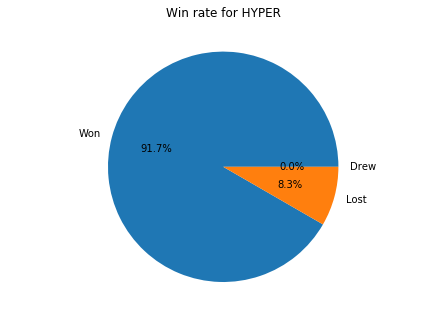

In [41]:
total_score = data['player_1_score'].sum(skipna = True)
total_count = data['player_1_score'].count()

print("The win rate for the agent \"" + str(data['player_1'][0]) + "\" playing the game \"" + str(data['game_name'][0]) + "\" is " + str(total_score/total_count) + "% for " + str(total_count) + " games")

# Display a pie chart
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
ax.set_title('Win rate for ' + str(data['player_1'][0]))
result = ['Won', 'Lost', 'Drew']
count = [len(data[(data['player_1_score'] == 100) & (data['player_2_score'] == 0)]), len(data[(data['player_1_score'] == 0) & (data['player_2_score'] == 100)]), len(data[(data['player_1_score'] == 100) & (data['player_2_score'] == 100)])]
ax.pie(count, labels = result,autopct='%1.1f%%')
plt.show()

### Move Results

Calculating the average move time per game

In [82]:
class Tracker:
    '''
    Tracker tracks the average time for each move of each game played
    '''
    def __init__(self):
        self.time_sum = 0
        self.num_moves = 0
        self.average_time = 0
        self.times = list()
    
    def __str__(self):
        return "time_sum: " + str(self.time_sum) + "\nnum_moves: " + str(self.num_moves) + "\naverage_time: " + str(self.average_time) + "\ntimes (ms): " + str(self.times)
    
    def addMove(self, num):
        self.time_sum += num
        self.num_moves+=1
        self.average_time = ((self.average_time*(self.num_moves - 1)) + num)/self.num_moves
        self.times.append(num)

# Add the results for each move of each game played to a list of trackers for the update and select move times for the chosen player      
time_to_update_list = list()
time_to_select_move_list = list()
player_name = 'XPLAYER'
for move_set in move_list:
    for index, move_row in move_set.iterrows():
        if move_row['role_name'] == player_name:
            if move_row['step'] > len(time_to_update_list) - 1:
                time_to_update_list.append(Tracker())
                time_to_select_move_list.append(Tracker())
            time_to_update_list[move_row['step']].addMove(move_row['time_to_update'])
            time_to_select_move_list[move_row['step']].addMove(move_row['time_to_select_move'])

# Print the data
for idx, (update_step, select_step) in enumerate(zip(time_to_update_list, time_to_select_move_list)):
    print('Step: ' + str(idx) + "\n")
    print('Time taken to update states:')
    print(str(update_step)  + "\n")
    print('Time taken to select move:')
    print(str(select_step)  + "\n\n\n")

Step: 0

Time taken to update states:
time_sum: 3
num_moves: 12
average_time: 0.25
times (ms): [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0]

Time taken to select move:
time_sum: 6430
num_moves: 12
average_time: 535.8333333333334
times (ms): [491, 561, 683, 530, 553, 536, 482, 490, 488, 562, 534, 520]



Step: 1

Time taken to update states:
time_sum: 408
num_moves: 12
average_time: 34.0
times (ms): [40, 46, 38, 40, 39, 30, 20, 31, 30, 30, 30, 34]

Time taken to select move:
time_sum: 53493
num_moves: 12
average_time: 4457.75
times (ms): [4259, 4295, 5020, 4259, 4671, 4199, 4702, 4412, 4431, 4678, 4251, 4316]



Step: 2

Time taken to update states:
time_sum: 1119
num_moves: 12
average_time: 93.25
times (ms): [100, 102, 118, 111, 110, 71, 71, 160, 69, 69, 69, 69]

Time taken to select move:
time_sum: 111760
num_moves: 12
average_time: 9313.333333333334
times (ms): [11171, 8527, 9680, 8052, 11230, 8120, 8180, 7339, 10600, 8861, 8450, 11550]



Step: 3

Time taken to update states:
time_sum: 1156